<a href="https://colab.research.google.com/github/Tamimi123600/Topic-Modelling/blob/main/Latent_Dirichlet_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling in Python: Latent Dirichlet Allocation (LDA)


In this project we are provided with a medical related dataset, containing 5k articles. I will be applying NLP, data-mining & topic extraction skills to extract the topics that are included within the dataset along with mapping each article to the corresponding topic names.

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns.Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

## Importing dependencies

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install --upgrade gensim==3.8

In [ ]:
# data handling
import pandas as pd 
import numpy as np 

import io
import os
from google.colab import files
import zipfile
import re
from pprint import pprint

# natural language toolkit
import nltk 
nltk.download('stopwords')

# Gensim libraries 
import gensim
# work with textual data
import gensim.corpora as corpora
# preprocess our data by gensim
from gensim.utils import simple_preprocess 
from gensim.models import CoherenceModel, Phrases
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.wrappers import LdaMallet
from gensim import corpora

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# Spacy libraries
import spacy 
from nltk.corpus import stopwords

# Visualization libraries 
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# ldamallet 
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
# importing java
def install_java():
  #install openjdk
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
  #set environment variable   
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     
  !java -version       
install_java()

In [ ]:
uploaded = files.upload()
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['Pubmed5k.xlsx']))
df

,ArticleID,Title,Abstract
0,34153941.0,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942.0,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964.0,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968.0,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978.0,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...
...,...,...,...
4994,34444567.0,Mind the Differences: How Diagnoses and Hospit...,Integrated care pathway (ICP) is a prevailing ...
4995,34444568.0,The Ethics of Dying: Deciphering Pandemic-Resu...,The objective of medicine is to provide humans...
4996,34444569.0,Research on Adolescents Regarding the Indirect...,This research involved the participation of 30...
4997,34444571.0,Pre-Intervention Effects of a Community-Based ...,This study explores the impact of the 'pre-int...


In [ ]:
# lets look at our first abstract
df['Abstract'][0]

'Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewer than 11 trials, CV was underestimated and led to an oversight of significant differences between 

## Preprocessing the data

Let's extract the abstract column to start preprocessing 
steps. Rather than having the column in a dataframe, we will convert the series into a list. 

In [ ]:
# extracting the Abstract column and converting it into a list
abstracts = df.Abstract.values.tolist()
abstracts

['Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewer than 11 trials, CV was underestimated and led to an oversight of significant differences between

### Cleaning the data

Now will perform some basic and initial clean up to the Abstracts. We'll take advantange of the regular expressions syntax.

In [ ]:
# remove new line characters
abstracts = [re.sub('\s+', ' ', abstract) for abstract in abstracts] 

# remove punctuations
abstracts = [re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', abstract) for abstract in abstracts]

# remove extra spaces
abstracts = [re.sub('\s+', ' ', abstract) for abstract in abstracts]

In [ ]:
# lets see how our first abstract transformed
abstracts[0]

'Coordination variability CV is commonly analyzed to understand dynamical qualities of human locomotion The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion Threedimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique The number of trials required to achieve a CV mean within 10 of 20 strides average was determined for each coupling and individual The statistical outputs of mode walking vs running and speed preferred vs fixed were compared when informed by differing numbers of trials A minimum of 11 trials were required for stable mean stance phase CV With fewer than 11 trials CV was underestimated and led to an oversight of significant differences between mode and speed F

### Lemmatization

Lemmatization is a process of returning a word to its root form.

In [ ]:
def lemmatization(abstracts, postags = ['NOUN','VERB','ADJ','ADV']):# will see if we need to reduce the postags list
   nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
   abstracts_out = []
   for abstract in abstracts:
        doc = nlp(abstract)
        new_text = []
        for token in doc:
            if token.pos_ in postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        abstracts_out.append(final)
   return (abstracts_out)

# lemmatizing all abstracts
abstracts_lemmatized = lemmatization(abstracts)

In [ ]:
# lets see how our first abstract is lemmatized
abstracts_lemmatized[0]

'coordination variability commonly analyze understand dynamical quality human locomotion purpose study develop guideline number trial require inform calculation stable mean low limb cv overground locomotion threedimensional low limb kinematic capture recreational runner perform trial preferred fix speed walking run phase calculate segment joint coupling use modify vector coding technique number trial require achieve mean stride average determine coupling individual statistical output mode walk run speed prefer fix compare when inform differ number trial minimum trial require stable mean stance phase few trial underestimate lead oversight significant difference mode speed future overground locomotion cv research healthy population use vector code approach should use trial standard minimum researcher should aware notable consequence insufficient number trial overall study finding'

### Tokenization

Tokenization is a process of turning a sentence into a list of words. 

In [ ]:
#  tokenizing the abstracts
def tokenization(abstracts):
  for abstract in abstracts:
    yield (gensim.utils.simple_preprocess(abstract))

# tokenizing all abstracts
abstract_words = list(tokenization(abstracts_lemmatized))

In [ ]:
# lets see how our first abstract is tokenized and split into list of words
print(abstract_words[0])

['coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'low', 'limb', 'cv', 'overground', 'locomotion', 'low', 'limb', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walking', 'run', 'phase', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'coding', 'technique', 'number', 'trial', 'require', 'achieve', 'mean', 'stride', 'average', 'determine', 'coupling', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'when', 'inform', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance', 'phase', 'few', 'trial', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 'cv', 'research', 'healthy', 'popul

### Create bi-grams and tri-grams

Bigrams are two adjacent frequent words occuring together and Trigrams are three adjacent words occuring together. We will use the Gensim's Phrases model to implement bigrams and trigrams. Two important arguments to note here: min_count and threshold. 

In [ ]:
# creating bigram and trigram objects
bigram = Phrases(abstract_words, min_count=3, threshold=100)
trigram = Phrases(bigram[abstract_words], threshold=100)

# creating bigram and trigram models 
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [ ]:
# lets again look at our first abstract
print(trigram_model[bigram_model[abstract_words[0]]])

['coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'low_limb', 'cv', 'overground', 'locomotion', 'low', 'limb_kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walking', 'run', 'phase', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'coding', 'technique', 'number', 'trial', 'require', 'achieve', 'mean', 'stride', 'average', 'determine', 'coupling', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'when', 'inform', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance_phase', 'few', 'trial', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 'cv', 'research', 'healthy', 'population', '

In [ ]:
# functions for bigrams and trigrams 
def apply_bigram(abstracts):
  return[bigram_model[abstract] for abstract in abstracts]

def apply_trigram(abstracts):
  return[trigram_model[bigram_model[abstract]] for abstract in abstracts]

### Remove Stopwords

In [ ]:
# download the stopwords
stop_words = stopwords.words('english')
# stop_words.extend([]) # will add words to the stopwords list to improve the model
len(stop_words)

179

In [ ]:
def remove_stopwords(abstracts):
  return [[word for word in simple_preprocess(str(abstract)) if word not in stop_words] for abstract in abstracts]

In [ ]:
# remove stopwords from abstract words list 
abstracts_without_stopwords = remove_stopwords(abstract_words)

In [ ]:
# form bigrams after removing stopwords
abstracts_bigrams = apply_bigram(abstracts_without_stopwords)

In [ ]:
# form trigrams from bigrams
abstracts_trigrams = apply_trigram(abstracts_bigrams)

In [ ]:
# let's now look at our first abstract after performing all these preprocessing steps
print(abstracts_trigrams[0])

['coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'human', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'mean', 'low_limb', 'cv', 'overground', 'locomotion', 'low', 'limb_kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'preferred', 'fix', 'speed', 'walking', 'run', 'phase', 'calculate', 'segment', 'joint', 'coupling', 'use', 'modify', 'vector', 'coding', 'technique', 'number', 'trial', 'require', 'achieve', 'mean', 'stride', 'average', 'determine', 'coupling', 'individual', 'statistical', 'output', 'mode', 'walk', 'run', 'speed', 'prefer', 'fix', 'compare', 'inform', 'differ', 'number', 'trial', 'minimum', 'trial', 'require', 'stable', 'mean', 'stance_phase', 'trial', 'underestimate', 'lead', 'oversight', 'significant', 'difference', 'mode', 'speed', 'future', 'overground', 'locomotion', 'cv', 'research', 'healthy', 'population', 'use', 'vector',

## LDA Model

### Creating dictionary and corpus

Now that we have our abstracts preprocessed and cleanded, we can go on and build the model. However, before building the model there are two paramters that need to be constructed (dictionary and corpus)

In [ ]:
# for simplicity will rename the abstracts_trigrams
Abstracts = abstracts_trigrams

In [ ]:
# creating a corpus
dictionary = corpora.Dictionary(Abstracts)
corpus = [dictionary.doc2bow(abstracts) for abstracts in Abstracts]

In [ ]:
# let's see now how first abstract looks like
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 1), (35, 1), (36, 3), (37, 2), (38, 2), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 3), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 8), (70, 1), (71, 1), (72, 3), (73, 1), (74, 2), (75, 1), (76, 1)]]


The reason the output of the corpus is shown like this is because Gensim creates a unique id for each word in the abstract hence the word dictionary. The produced corpus shown above is a mapping of (word_id, word_frequency). That is in our first abstract (0,1) means word_id '0' occurs once in that abstract. 

Let's see what that word is:


In [ ]:
# word corresponding to the first tuple in the corpus
dictionary[0]

'achieve'

In [ ]:
# frequencies of the words in the first abstract
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('achieve', 1),
  ('analyze', 1),
  ('approach', 1),
  ('average', 1),
  ('aware', 1),
  ('calculate', 1),
  ('calculation', 1),
  ('capture', 1),
  ('code', 1),
  ('coding', 1),
  ('commonly', 1),
  ('compare', 1),
  ('consequence', 1),
  ('coordination', 1),
  ('coupling', 2),
  ('cv', 2),
  ('determine', 1),
  ('develop', 1),
  ('differ', 1),
  ('difference', 1),
  ('dynamical', 1),
  ('finding', 1),
  ('fix', 2),
  ('future', 1),
  ('guideline', 1),
  ('healthy', 1),
  ('human', 1),
  ('individual', 1),
  ('inform', 2),
  ('insufficient', 1),
  ('joint', 1),
  ('lead', 1),
  ('limb_kinematic', 1),
  ('locomotion', 3),
  ('low', 1),
  ('low_limb', 1),
  ('mean', 3),
  ('minimum', 2),
  ('mode', 2),
  ('modify', 1),
  ('notable', 1),
  ('number', 4),
  ('output', 1),
  ('overall', 1),
  ('overground', 2),
  ('oversight', 1),
  ('perform', 1),
  ('phase', 1),
  ('population', 1),
  ('prefer', 1),
  ('preferred', 1),
  ('purpose', 1),
  ('quality', 1),
  ('recreational', 1),
  ('requ

### Creating the Model

#### Num_topics = 20

In [ ]:
# creating and training the lda model 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, # number of requested topics to be extracted 
                                           random_state=100, 
                                           update_every=1, # number of documents to be iterated through for each update
                                           chunksize=100, # number of documentsto be used in each training chunk
                                           passes=10, # number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

#### Num_topics = 15

In [ ]:
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=15,  
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Num_topics = 10

In [ ]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10,  
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Num_topics = 5

In [ ]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,  
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Num_topics = 3

In [ ]:
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=3,  
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Printing keywords for each topic and the weight of each keyword

In [ ]:
# the keyword in the first 10 topics for our first lda model
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.049*"patient" + 0.034*"study" + 0.021*"group" + 0.018*"treatment" + 0.014*"clinical" + 0.013*"level" + 0.013*"compare" + 0.012*"rate" + 0.012*"use" + 0.012*"case"


Topic: 1 
Words: 0.197*"covid" + 0.190*"pandemic" + 0.044*"antibody" + 0.036*"emergency" + 0.029*"utilization" + 0.016*"prostate_cancer" + 0.014*"conflict" + 0.010*"spike" + 0.008*"commercially_available" + 0.007*"collectively"


Topic: 2 
Words: 0.090*"risk" + 0.075*"age" + 0.053*"year" + 0.044*"child" + 0.042*"factor" + 0.042*"associate" + 0.035*"association" + 0.028*"woman" + 0.026*"prevalence" + 0.025*"high"


Topic: 3 
Words: 0.105*"infection" + 0.070*"drug" + 0.063*"virus" + 0.045*"induce" + 0.037*"assay" + 0.029*"viral" + 0.027*"respiratory" + 0.027*"vaccination" + 0.027*"activation" + 0.026*"transmission"


Topic: 4 
Words: 0.055*"variant" + 0.044*"series" + 0.039*"compound" + 0.026*"raise" + 0.024*"spectrum" + 0.019*"artery" + 0.016*"ligand" + 0.016*"endogenous" + 0.015*"transcription_factor" + 0

Now that is a very useful and detailed information up there. How do we interpret it? 

The numbers shown are the weights describing the importance of each word in a specific topic. For example, looking at Topic 19, the top 10 keywords corresponding to that Topic are cell, protein, gene, expression, mechanism, response, function, pathway, role and human. The numbers beside each word are weights that reflect to how important that keyword is to that topic. 

## Model Perplexity and Coherence


Model perplexity and coherence provide a stastical measure to judge and predict how good a given topic model is. The lower the perplexity the better the model is performing. 

In [ ]:
print('Performance of the lda model with num-topics = 20')
# model perplexity 
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# model coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Performance of the lda model with num-topics = 20

Perplexity:  -14.276744551428008

Coherence Score:  0.44174819327581655


In [ ]:
print('Performance of the lda model with num-topics = 15')
# model perplexity 
print('\nPerplexity: ', lda_model1.log_perplexity(corpus))

# model coherence score
coherence_model_lda1 = CoherenceModel(model=lda_model1, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)

Performance of the lda model with num-topics = 15

Perplexity:  -12.742207696725021

Coherence Score:  0.47420770906996684


In [ ]:
print('Performance of the lda model with num-topics = 10')
# model perplexity 
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))

# model coherence score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)

Performance of the lda model with num-topics = 10

Perplexity:  -9.154322443172427

Coherence Score:  0.4485826078508934


In [ ]:
print('Performance of the lda model with num-topics = 5')
# model perplexity 
print('\nPerplexity: ', lda_model3.log_perplexity(corpus))

# model coherence score
coherence_model_lda3 = CoherenceModel(model=lda_model3, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda3 = coherence_model_lda3.get_coherence()
print('\nCoherence Score: ', coherence_lda3)

Performance of the lda model with num-topics = 5

Perplexity:  -8.370348565374814

Coherence Score:  0.4094857994574747


In [ ]:
print('Performance of the lda model with num-topics = 3')
# model perplexity 
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))

# model coherence score
coherence_model_lda4 = CoherenceModel(model=lda_model4, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda4 = coherence_model_lda4.get_coherence()
print('\nCoherence Score: ', coherence_lda4)

Performance of the lda model with num-topics = 3

Perplexity:  -8.311551843288761

Coherence Score:  0.36139137170593383


## Visualizing the data

In [ ]:
# Visualize the model with 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.371142  0.070405       1        1  26.560695
14    -0.355377  0.085058       2        1  21.660139
7     -0.344113  0.187503       3        1  20.258792
16    -0.190306 -0.238000       4        1   5.812808
9     -0.128835 -0.285739       5        1   5.621888
19    -0.120825  0.089832       6        1   4.650732
2     -0.126238 -0.103374       7        1   4.644927
15     0.049117 -0.044455       8        1   1.932178
8      0.057462 -0.033412       9        1   1.693413
3      0.090045  0.013481      10        1   1.423972
17     0.094415  0.009386      11        1   1.351979
18     0.102988  0.011974      12        1   1.034421
11     0.133955  0.023824      13        1   0.693075
6      0.142977  0.029186      14        1   0.663839
1      0.133034  0.023593      15        1   0.616511
12     0.148724  0.029394      16        1   0.550819
4      0.165067  0.032501      17        1   0.389621
10     0.165002  0.032337      18        1   0.265902
13     0.176420  0.033224      19        1   0.116952
5      0.177631  0.033282      20        1   0.057337, topic_info=             Term         Freq        Total Category  logprob  loglift
169       patient  6845.000000  6845.000000  Default  30.0000  30.0000
120          risk  2195.000000  2195.000000  Default  29.0000  29.0000
373          cell  2190.000000  2190.000000  Default  28.0000  28.0000
287        health  2087.000000  2087.000000  Default  27.0000  27.0000
130           age  1819.000000  1819.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3940     quantify     0.008247     1.032854  Topic20 -10.5012   2.6338
3890         room     0.008247     1.032826  Topic20 -10.5012   2.6338
3505     validate     0.008247     1.032857  Topic20 -10.5012   2.6338
5724  reliability     0.008247     1.032832  Topic20 -10.5012   2.6338
5567         bias     0.008247     1.032857  Topic20 -10.5012   2.6338

[804 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2351     17  0.902081      ablation
1379      4  0.994085      academic
1698     13  0.966291    accordance
679       6  0.993962  accumulation
1941      5  0.997975      accuracy
...     ...       ...           ...
188       1  0.398683          year
188       7  0.600825          year
267       4  0.005919         young
267       7  0.991510         young
2958     12  0.987538         youth

[857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 15, 8, 17, 10, 20, 3, 16, 9, 4, 18, 19, 12, 7, 2, 13, 5, 11, 14, 6])

In [ ]:
# Visualize the model with 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model1, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.349828  0.036847       1        1  32.341773
0     -0.302641  0.136504       2        1  18.891956
9     -0.306068  0.063051       3        1  15.720776
14    -0.271413 -0.241317       4        1  15.459131
3     -0.158335 -0.212542       5        1   7.467715
2     -0.057291  0.279050       6        1   3.522587
4      0.107476 -0.008044       7        1   1.879335
1      0.149245 -0.014010       8        1   0.933823
8      0.153104 -0.005728       9        1   0.904825
11     0.164369 -0.005651      10        1   0.642177
6      0.169673 -0.005627      11        1   0.563660
5      0.170246 -0.005945      12        1   0.494282
13     0.171636 -0.005924      13        1   0.486446
12     0.177643 -0.005504      14        1   0.419622
10     0.182184 -0.005159      15        1   0.271892, topic_info=               Term         Freq        Total Category  logprob  loglift
169         patient  6968.000000  6968.000000  Default  30.0000  30.0000
373            cell  2244.000000  2244.000000  Default  29.0000  29.0000
130             age  1699.000000  1699.000000  Default  28.0000  28.0000
120            risk  2076.000000  2076.000000  Default  27.0000  27.0000
188            year  2059.000000  2059.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3800      excretion     0.032256     1.019007  Topic15 -10.6939   2.4546
3196         sodium     0.032292     1.020268  Topic15 -10.6928   2.4545
30815  solid_litter     0.032154     1.018176  Topic15 -10.6971   2.4523
3110       division     0.032183     1.019179  Topic15 -10.6962   2.4522
3130     government     0.032244     1.023127  Topic15 -10.6943   2.4502

[636 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2351     13  0.900634     ablation
1229      7  0.987205     abnormal
1941      4  0.998596     accuracy
0         2  0.117906      achieve
0         4  0.879757      achieve
...     ...       ...          ...
188       2  0.403438         year
188       3  0.113604         year
188       6  0.478688         year
267       6  0.998447        young
1528      8  0.963169  young_adult

[744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 10, 15, 4, 3, 5, 2, 9, 12, 7, 6, 14, 13, 11])

In [ ]:
# Visualize the model with 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.199677  0.040880       1        1  24.373112
7     -0.249352  0.025960       2        1  21.681652
0     -0.223268  0.002912       3        1  20.931664
3     -0.100402  0.225819       4        1  12.207408
2     -0.112474 -0.152148       5        1   7.755860
6      0.027966 -0.321337       6        1   5.598231
4      0.123103  0.112446       7        1   4.841776
1      0.245990  0.026399       8        1   1.277471
8      0.248288  0.014958       9        1   0.910450
5      0.239826  0.024111      10        1   0.422376, topic_info=                  Term         Freq        Total Category  logprob  loglift
169            patient  5552.000000  5552.000000  Default  30.0000  30.0000
120               risk  1708.000000  1708.000000  Default  29.0000  29.0000
287             health  1644.000000  1644.000000  Default  28.0000  28.0000
373               cell  1800.000000  1800.000000  Default  27.0000  27.0000
130                age  1424.000000  1424.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
4469           arsenic     5.235138     6.117253  Topic10  -6.0449   5.3113
2544             plane     5.000680     5.883054  Topic10  -6.0908   5.3045
21537         selenium     4.997003     5.879144  Topic10  -6.0915   5.3045
561               diet    48.893688    70.930702  Topic10  -3.8107   5.0950
3871   supplementation    13.971543    43.009142  Topic10  -5.0633   4.3426

[530 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1379      6  0.992957       academic
315       6  0.995280         access
5485      9  0.960096  accessibility
1941      1  0.997705       accuracy
1942      1  0.186968           acid
...     ...       ...            ...
188       3  0.411656           year
188       5  0.575610           year
267       3  0.056555          young
267       5  0.938812          young
1528      8  0.980458    young_adult

[780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 1, 4, 3, 7, 5, 2, 9, 6])

In [ ]:
# Visualize the model with 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model3, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.027102  0.134694       1        1  28.180232
3      0.049951  0.190103       2        1  23.766024
0     -0.105236 -0.053564       3        1  22.389706
4      0.240144 -0.168709       4        1  13.056471
2     -0.211961 -0.102524       5        1  12.607567, topic_info=           Term         Freq        Total Category  logprob  loglift
169     patient  5207.000000  5207.000000  Default  30.0000  30.0000
120        risk  1569.000000  1569.000000  Default  29.0000  29.0000
373        cell  1606.000000  1606.000000  Default  28.0000  28.0000
130         age  1291.000000  1291.000000  Default  27.0000  27.0000
264   treatment  1871.000000  1871.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
153    estimate   258.285085   441.652670   Topic5  -5.5424   1.5344
219       group   405.882519  2105.956826   Topic5  -5.0904   0.4244
150     disease   349.568927  1314.673275   Topic5  -5.2398   0.7462
19   difference   299.897391   839.597215   Topic5  -5.3930   1.0414
11      compare   332.346793  1472.880158   Topic5  -5.2903   0.5821

[356 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
315       1  0.997844      access
2693      2  0.993481  activation
682       1  0.261045    activity
682       2  0.726069    activity
682       5  0.013356    activity
...     ...       ...         ...
188       1  0.057093        year
188       3  0.368153        year
188       5  0.574870        year
267       3  0.132859       young
267       5  0.863585       young

[617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [ ]:
# Visualize the model with 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model4, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.167030  0.075363       1        1  36.620685
2     -0.007046 -0.161142       2        1  35.782869
0     -0.159985  0.085779       3        1  27.596445, topic_info=          Term         Freq        Total Category  logprob  loglift
169    patient  4998.000000  4998.000000  Default  30.0000  30.0000
287     health  1495.000000  1495.000000  Default  29.0000  29.0000
373       cell  1547.000000  1547.000000  Default  28.0000  28.0000
264  treatment  1819.000000  1819.000000  Default  27.0000  27.0000
201   clinical  1361.000000  1361.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
154   evaluate   503.451675  1045.771734   Topic3  -5.6584   0.5565
106   increase   615.297762  2070.619287   Topic3  -5.4578   0.0740
34         low   506.450531  1285.183452   Topic3  -5.6525   0.3563
131        aim   489.068740  1199.974915   Topic3  -5.6874   0.3899
180     result   490.257757  2382.536155   Topic3  -5.6849  -0.2935

[233 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
315       2  0.994054    access
682       1  0.667519  activity
682       2  0.264989  activity
682       3  0.066878  activity
190       2  0.004647     acute
...     ...       ...       ...
1697      1  0.998818     water
357       2  0.136529      week
357       3  0.863693      week
188       2  0.392252      year
188       3  0.607528      year

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

## LDA Mallet Model

Mallet is an open source toolkit used for NLP, topic modelling, clustering and many other applications. It often gives a better quality of topics. Let's see if we can increase the coherence score of our LDA model. 

In [ ]:
# create ldamallet object
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=dictionary)
# show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('cell', 0.011539675525535004),
   ('effect', 0.008137112556025504),
   ('show', 0.007625781200681775),
   ('increase', 0.006767249542326873),
   ('protein', 0.006199103591944953),
   ('result', 0.0061864781263809105),
   ('gene', 0.005971845211792184),
   ('level', 0.0056688340382551605),
   ('activity', 0.0055552048481787766),
   ('high', 0.005346884666372073)]),
 (1,
  [('study', 0.02095879395822125),
   ('risk', 0.009371583276930285),
   ('health', 0.009290594285648173),
   ('datum', 0.00916332587077628),
   ('factor', 0.008318726390262808),
   ('age', 0.008312941462314087),
   ('associate', 0.008023695064877967),
   ('care', 0.006814645123594985),
   ('include', 0.0066237425012871465),
   ('high', 0.006606387717440979)]),
 (2,
  [('patient', 0.03277926970510748),
   ('group', 0.013980985350829186),
   ('treatment', 0.011823700856550127),
   ('study', 0.01001005460029782),
   ('compare', 0.00989550852095557),
   ('model', 0.009348232808542592),
   ('clinical', 0.00906823128

In [ ]:
# coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=Abstracts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3771183228115986


## Optimal number of Topics

In [ ]:
# function to compute the coherence scores
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=Abstracts, start=2, limit=40, step=6)

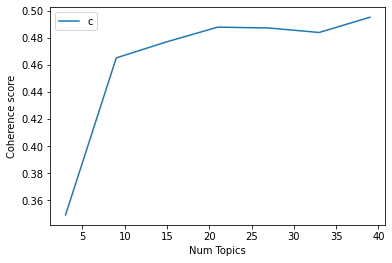

In [ ]:
limit=40; start=3; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3492
Num Topics = 9  has Coherence Value of 0.4652
Num Topics = 15  has Coherence Value of 0.4772
Num Topics = 21  has Coherence Value of 0.4879
Num Topics = 27  has Coherence Value of 0.4873
Num Topics = 33  has Coherence Value of 0.484
Num Topics = 39  has Coherence Value of 0.4953


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"activity" + 0.020*"show" + 0.011*"potential" + 0.010*"study" + '
  '0.010*"interaction" + 0.009*"protein" + 0.009*"strain" + 0.009*"effect" + '
  '0.009*"variant" + 0.009*"isolate"'),
 (1,
  '0.016*"study" + 0.015*"participant" + 0.013*"experience" + 0.012*"impact" + '
  '0.011*"stress" + 0.011*"factor" + 0.011*"questionnaire" + 0.011*"people" + '
  '0.011*"student" + 0.010*"physical"'),
 (2,
  '0.065*"cell" + 0.030*"gene" + 0.028*"expression" + 0.026*"protein" + '
  '0.018*"response" + 0.011*"pathway" + 0.011*"mouse" + 0.011*"function" + '
  '0.011*"human" + 0.011*"mechanism"'),
 (3,
  '0.021*"area" + 0.019*"increase" + 0.018*"water" + 0.015*"environmental" + '
  '0.014*"effect" + 0.013*"impact" + 0.012*"result" + 0.011*"show" + '
  '0.011*"condition" + 0.011*"environment"'),
 (4,
  '0.170*"patient" + 0.039*"disease" + 0.036*"clinical" + 0.018*"score" + '
  '0.017*"include" + 0.014*"severe" + 0.013*"outcome" + 0.013*"associate" + '
  '0.012*"chronic" + 0.011*"symptom"')

## Topic Modelling

### Dominant Topic

After selecting the model to work with, now will go ahead and find the dominant topic in each abstract. Determining the topic in which a specific abstract is about is one of the practical applicaitons of topic modelling. In order to do that, we need to find the topic number that has the highest percentage contribution in that respective abstract. 

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=abstracts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # main topic in each abstract
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # getting the dominant topic, percentage contribution and keywords for each documnet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=abstracts)

In [ ]:
# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,0,10.0,0.1446,"network, show, brain, change, function, indivi...",Coordination variability CV is commonly analyz...
1,1,5.0,0.1836,"difference, study, pain, compare, evaluate, gr...",Clinical Scenario Dynamic knee valgus DKV is a...
2,2,17.0,0.1443,"risk, age, year, associate, high, child, study...",Various methodologies have been reported to as...
3,3,17.0,0.2082,"risk, age, year, associate, high, child, study...",As outcomes for acute ischemic stroke AIS vary...
4,4,17.0,0.2704,"risk, age, year, associate, high, child, study...",Because hearing loss in children can result in...
5,5,19.0,0.2322,"treatment, group, intervention, control, impro...",Despite growing numbers in the USA immigrant p...
6,6,19.0,0.1317,"treatment, group, intervention, control, impro...",Historically the treatment of lupus nephritis ...
7,7,4.0,0.1453,"patient, disease, clinical, score, include, se...",Progressive chronic kidney disease CKD in indi...
8,8,4.0,0.1618,"patient, disease, clinical, score, include, se...",Immunoglobulin A nephropathy IgAN is the most ...
9,9,12.0,0.1036,"development, provide, system, approach, human,...",In kidney transplantation precision medicine h...


In [ ]:
# let's take a look at the keywords for the first abstract
df_dominant_topic.Keywords[0]

'network, show, brain, change, function, individual, task, control, dynamic, result'

### Most representative abstract for each topic

The above table is not that informative, let's go ahead and find the abstracts a given topic has contributed to the most and infer the topic by reading that abstract. 

In [ ]:
# group top 5 abstracts under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Abstract"]
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Abstract
0,0.0,0.5140,"activity, show, potential, study, interaction,...",This study assessed the antioxidant properties...
1,1.0,0.4966,"study, participant, experience, impact, stress...",We investigated whether perceived social suppo...
2,2.0,0.5429,"cell, gene, expression, protein, response, pat...",Breast cancer is the leading cause of cancerre...
3,3.0,0.5934,"area, increase, water, environmental, effect, ...",Aquatic ecosystems are exposed to multiple env...
4,4.0,0.4357,"patient, disease, clinical, score, include, se...",Patients with advanced pancreatic cancer APC e...


### Topic distribution across abstracts


Lets understand the volume and distribution of topics in order to judge how widely it was discussed.

In [ ]:
# number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# percentage of documents for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Abstracts', 'Percentage_Abstracts']
df_dominant_topics.head(100)

,Dominant_Topic,Topic_Keywords,Num_Abstracts,Percentage_Abstracts
0.0,10.0,"network, show, brain, change, function, indivi...",258.0,0.0516
1.0,5.0,"difference, study, pain, compare, evaluate, gr...",317.0,0.0634
2.0,17.0,"risk, age, year, associate, high, child, study...",459.0,0.0918
3.0,17.0,"risk, age, year, associate, high, child, study...",198.0,0.0396
4.0,17.0,"risk, age, year, associate, high, child, study...",233.0,0.0466
...,...,...,...,...
95.0,12.0,"development, provide, system, approach, human,...",NaN,NaN
96.0,12.0,"development, provide, system, approach, human,...",NaN,NaN
97.0,7.0,"health, care, service, community, access, prog...",NaN,NaN
98.0,1.0,"study, participant, experience, impact, stress...",NaN,NaN


## Discussion

### Key Notes

- We have trained the model on different number of topics to see how the model would repsond. From the above iterations, we can see that by decreasing the number of topics, the model has performed better.

- Each bubble in the visualization charts represent a topic. The larger the bubble, the more prevalent is that topic. A good model will have big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. Hence, the reason why we kept decreasing the number of topics to have a better model perplexity and a chart that doesn't have overlapping bubbles.

- By changing the LDA algorithm, the Coherence Score increased from 0.3613 to 0.3916. That is an 8% increase which is a quite a good thing.

- The way we went on to choose the appropriate number of topics is by a technique called *elbow technique.* Usually increasing the number of topics increases the coherence score. This is illuastrated in the figure below. We want to choose a point after which the diminshing increase of coherence score is no longer worth the additional increase of the number of topics. Therefore we used the elbow curve to select the number of topics. Also, we considered the highest coherence score before flattening out.

- We were able to understand the distribution of topics across the abstracts. For example, 459 abstracts were about topic 17 and 258 abstracts were about topic 10. As you can also see from the tabular output above, some entries are not shown this is a sign that there is always room for improvement.


### Improvements

In order to have a good model, we assess the model in three different ways:


1.   How are the topics interpretable?
2.   Whether the topics are unique?
3.   Are the documents represented by the topics extracted?

Some fine-tuning steps could be taken such as:

- Adding stopwords that are too frequent in the topics. 
- Keeping only nouns and verbs and see how this would affect the model
- Tweaking alpha and eta would be a great option to adjust the topics. 
- Tweaking with the number of *passes.*
